In [88]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [89]:
trenovacie = pd.read_csv("data/predspracovane_train.csv")

In [90]:
trenovacie['class'].unique()

array(['negative', 'increased binding protein',
       'decreased binding protein'], dtype=object)

In [91]:
cls = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = trenovacie[['TT4', 'T4U', 'T3']]
y = trenovacie['class']
cls.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [92]:
overovacie = pd.read_csv("data/predspracovane_valid.csv")
testovacie = pd.read_csv("data/predspracovane_test.csv")


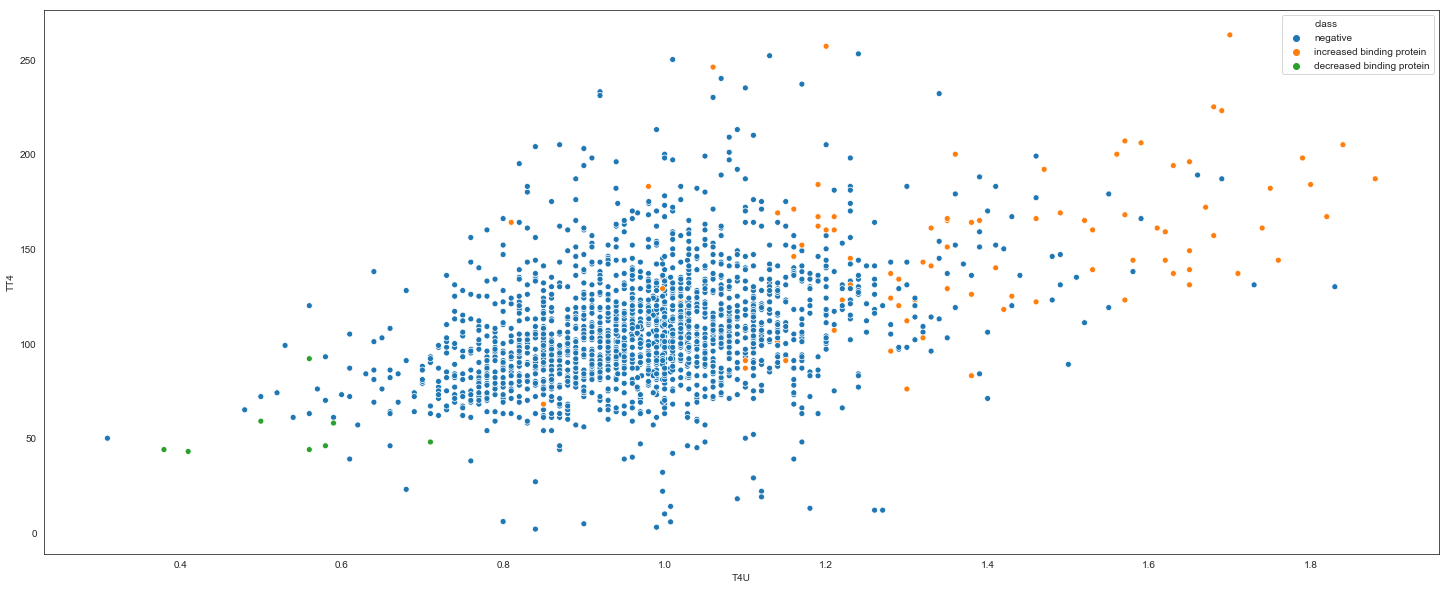

In [93]:
sns.scatterplot('T4U', 'TT4', data=trenovacie[['T4U', 'TT4', 'class']], hue='class')

Pre manualne pravidla rozhodovania sme zvolili atributy T4U a TT4. Podla scatterplotu vidno, ze maju vplyv na class. Increased binding protein bude ked je T4U viac ako 1.2 alebo TT4 viac ako 172. Decreased ak je T4U menej ako 0.7 alebo TT4 menej ako 50. V ostatnych pripadoch je negative.

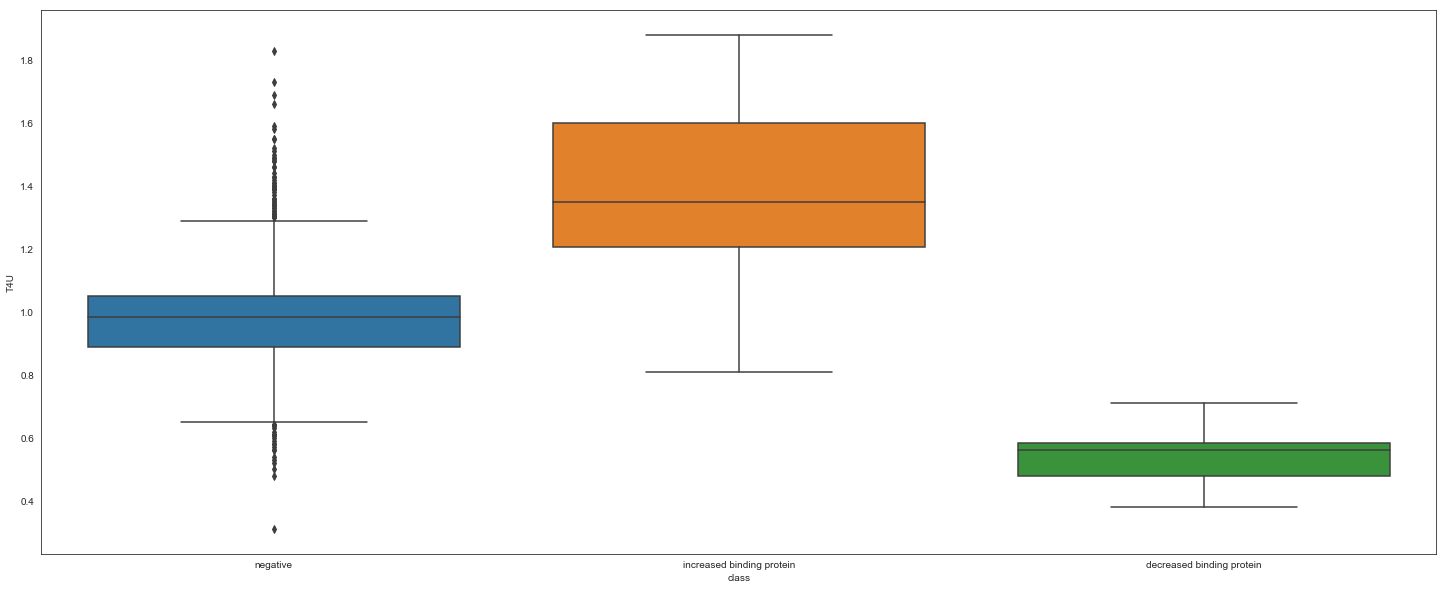

In [94]:
sns.boxplot('class', 'T4U', data=trenovacie)

Na pravidlo podla jedneho atributu sme zvolil T4U, lebo sa zda mat najmenej prekryvajucich sa hodnot. Hranica medzi Increased binding protein a negative je T4U=1,1, medzi Decreased binding protein a negative je T4U=0.7

In [95]:
def podla_testyriu(data):
    vysledok = []
    for zaznam in data['T4U']:
        if zaznam < 0.7:
            vysledok.append('decreased binding protein')
        elif zaznam > 1.1:
            vysledok.append('increased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_jeden = podla_testyriu(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S JEDNYM ATRIBUTOM
print('Accuracy \t: ' + str(accuracy_score(overovacie['class'], manualna_jeden)))
print('Precision\t: ' + str(precision_score(overovacie['class'], manualna_jeden, average='macro')))
print('Recall \t: ' + str(recall_score(overovacie['class'], manualna_jeden, average='macro')))


Accuracy 	: 0.8083067092651757
Precision	: 0.4266521724607551
Recall 	: 0.9058845988641245


In [96]:
def podla_testyriuaajtetestyritamdajmenechjesranda(data):
    vysledok = []
    for testyriu, tetestyri in data[['T4U', 'TT4']].values:
        # 172, 1.2
        # print(zaznam)
        if testyriu > 1.2 or tetestyri > 172:
            vysledok.append('increased binding protein')
        elif testyriu < 0.7 or tetestyri < 50:
            vysledok.append('decreased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok

manualna_dva = podla_testyriuaajtetestyritamdajmenechjesranda(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S DVOMA ATRIBUTMI
print('Accuracy \t: ' + str(accuracy_score(overovacie['class'], manualna_dva)))
print('Precision\t: ' + str(precision_score(overovacie['class'], manualna_dva, average='macro')))
print('Recall \t: ' + str(recall_score(overovacie['class'], manualna_dva, average='macro')))

Accuracy 	: 0.8690095846645367
Precision	: 0.43304718034617534
Recall 	: 0.8984870901541546


In [97]:
pred = cls.predict(overovacie[['TT4', 'T4U', 'T3']])

In [98]:

accuracy_score(overovacie['class'], pred)
f1_score(overovacie['class'], pred, average='macro')


0.7289473684210526

In [99]:
X_train = trenovacie[['TT4', 'T4U', 'T3']]
y_train = trenovacie['class']
results = []
X_test = overovacie[['TT4', 'T4U', 'T3']]
y_test = overovacie['class']
estimators = []
for i in range(1, 20):
    row = {'model_complexity': i}
    # Vytvoríme rozhodovací strom
    clf = DecisionTreeClassifier(max_depth = i) # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu

    pred = clf.fit(X_train, y_train).predict(X_train) # natrenovanie modelu a predikovanie na trenovacej sade
    row['train_accuracy'] = accuracy_score(y_train, pred) # chyba na trenovacej sade
    row['train_f1'] = f1_score(y_train, pred, average='macro') # chyba na trenovacej sade

    pred = clf.predict(X_test)
    row['test_accuracy'] = accuracy_score(y_test, pred) # chyba na testovacej sade
    row['test_f1'] = f1_score(y_test, pred, average='macro') 
    results.append(row)
    estimators.append(clf)

C:\Programs\Python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Programs\Python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Programs\Python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Programs\Python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Programs\Python\lib\site-packages\sklearn\metrics\classification.py:1143: Undefin

In [100]:
complexity_df = pd.DataFrame(results)
complexity_df.head(10)

,model_complexity,test_accuracy,test_f1,train_accuracy,train_f1
0,1,0.956337,0.492412,0.955484,0.518254
1,2,0.973376,0.510595,0.970170,0.524831
2,3,0.973376,0.510595,0.970170,0.524831
3,4,0.970181,0.723579,0.974759,0.832633
4,5,0.974441,0.747234,0.982561,0.876180
5,6,0.974441,0.782266,0.989904,0.935557
6,7,0.969116,0.715377,0.993116,0.969216
7,8,0.966986,0.723910,0.995411,0.980043
8,9,0.969116,0.737098,0.997246,0.988284
9,10,0.970181,0.746713,0.997246,0.988408


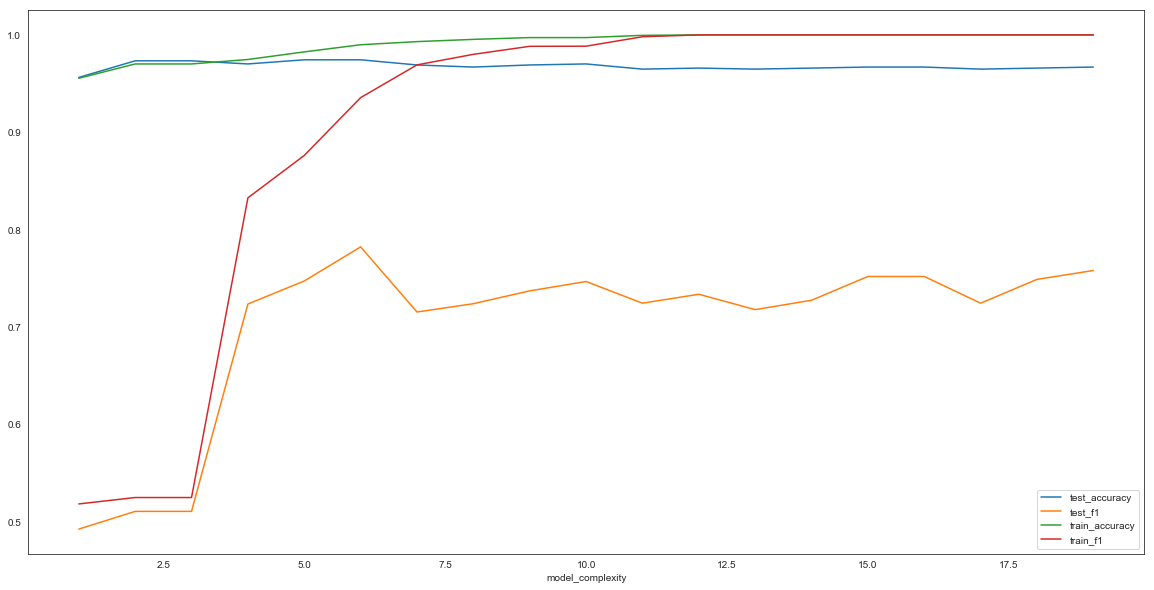

In [101]:
complexity_df.plot(x='model_complexity', figsize=(20, 10))